# Explore the outcome of a hyperparameter sweep for metric correlation between datasets

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sys

pd.options.display.max_colwidth = None
MODULE_PATH =  Path(os.getcwd()).parents[1].resolve()

In [2]:
%cd {MODULE_PATH}

/home/shaul/workspace/GitHub/SOTA


In [3]:
path_combined = 'combined_dataset.csv'
path_sts = 'sts.csv'
path_qqp = 'qqp.csv'
path_sample_qqp = 'sample_qqp.csv'
report_file = "wandb_sweeping.csv"

PATH_DATA = MODULE_PATH / 'data'
PATH_COMBINED = PATH_DATA / 'datasets' / path_combined
PATH_STS = PATH_DATA / 'datasets' / path_sts
PATH_SAMPLE_QQP = PATH_DATA / 'datasets' / path_sample_qqp

In [4]:
df = pd.read_csv(PATH_DATA / 'reports' / report_file, index_col="Name")

df['RF Increase'] = df['RF PearsonR'] - df['Base Top Correlation']
df['RF Increase Percentage'] = df['RF Increase'] / df['Base Top Correlation']

## Find the cases where the RF Increase is the highest

In [6]:
train_dataset = path_sts
test_dataset = path_combined
filtered = False

if filtered:
    display(df[(df['train_dataset'] == train_dataset) & (df['test_dataset'] == test_dataset) & (~df['bad_annotators'].isnull())] \
    .sort_values(by="RF Increase",ascending=False)[:3])
else:
    display(df[(df['train_dataset'] == train_dataset) & (df['test_dataset'] == test_dataset) & (df['bad_annotators'].isnull())] \
    .sort_values(by="RF Increase",ascending=False)[:3])

,State,Notes,User,bad_annotators,rf_depth,rf_top_n_features,scale_features,scale_labels,test_dataset,train_dataset,Base Top Correlation,RF PearsonR,RF Increase,RF Increase Percentage
Name,,,,,,,,,,,,,,
kind-lion-110,finished,-,sota-mafat,NaN,6,4,False,False,combined_dataset.csv,sts.csv,0.484469,0.477157,-0.007312,-0.015093
glowing-butterfly-80,finished,-,sota-mafat,NaN,6,4,True,False,combined_dataset.csv,sts.csv,0.484469,0.476840,-0.007628,-0.015746
absurd-shape-83,finished,-,sota-mafat,NaN,7,4,True,False,combined_dataset.csv,sts.csv,0.484469,0.475857,-0.008611,-0.017774


## Visualize how the RF changes overall

In [7]:
# We need to get rid of cases where you reduce labels - because they only hurt performace
df = df[df['scale_labels'] == False]

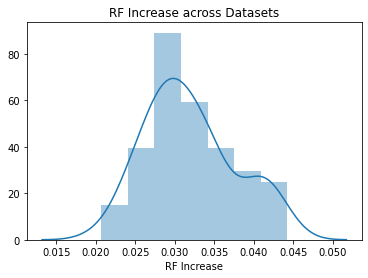

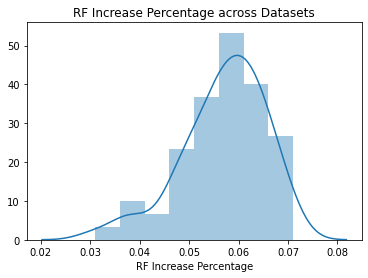

In [8]:
sns.distplot(df[(df['train_dataset'] != df['test_dataset']) & (df['test_dataset'].isna())]['RF Increase']);
plt.title("RF Increase across Datasets")
plt.show()
sns.distplot(df[(df['train_dataset'] != df['test_dataset']) & (df['test_dataset'].isna())]['RF Increase Percentage']);
plt.title("RF Increase Percentage across Datasets")
plt.show();

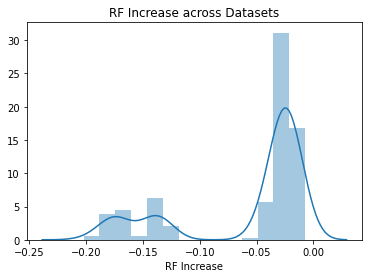

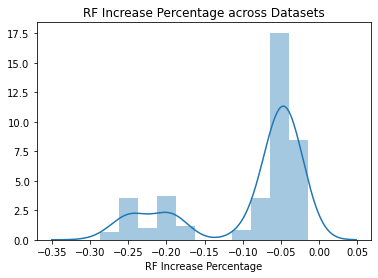

In [9]:
sns.distplot(df[(df['train_dataset'] != df['test_dataset']) & (~df['test_dataset'].isna())]['RF Increase']);
plt.title("RF Increase across Datasets")
plt.show()
sns.distplot(df[(df['train_dataset'] != df['test_dataset']) & (~df['test_dataset'].isna())]['RF Increase Percentage']);
plt.title("RF Increase Percentage across Datasets")
plt.show();

In [33]:
idx = df[df['train_dataset'] != df['test_dataset']]['RF Increase'].sort_values(ascending=True)[:5].index
display(df.loc[idx])

,bad_annotators,rf_depth,rf_top_n_features,scale_features,scale_labels,test_dataset,train_dataset,Base Top Correlation,RF PearsonR,RF Increase,RF Increase Percentage
Name,,,,,,,,,,,
astral-totem-178,ba_all.txt,9,3,False,False,sts.csv,combined_dataset.csv,0.705798,0.503598,-0.202199,-0.286484
devout-night-148,ba_all.txt,9,3,True,False,sts.csv,combined_dataset.csv,0.705798,0.513864,-0.191933,-0.271938
rare-frost-150,ba_all.txt,9,5,True,False,sts.csv,combined_dataset.csv,0.705798,0.518131,-0.187666,-0.265893
legendary-meadow-145,ba_all.txt,8,3,True,False,sts.csv,combined_dataset.csv,0.705798,0.519893,-0.185904,-0.263396
polar-feather-177,ba_all.txt,8,5,False,False,sts.csv,combined_dataset.csv,0.705798,0.522014,-0.183783,-0.260391


## Exploring some SHAP

In [99]:
from src import model_corr
import shap
from sklearn.ensemble import RandomForestRegressor

In [103]:
shap.initjs()

In [111]:
metrics = ['bleu', 
           'bleu1',
           'glove_cosine',
           'fasttext_cosine',
           'BertScore',
           'chrfScore',
           'POS Dist score',
           '1-gram_overlap',
           'ROUGE-1',
           'ROUGE-2',
           'ROUGE-l',
           'L2_score',
           'WMD']

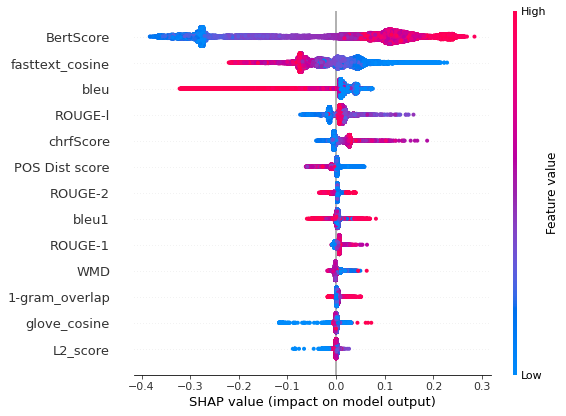

In [119]:
df = pd.read_csv(PATH_SAMPLE_QQP)
df.dropna(inplace=True)
model = RandomForestRegressor(max_depth=6)
model.fit(df[metrics], df['label'])

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df[metrics])

shap.summary_plot(shap_values, df[metrics])

## Exploring transferability from Combined to other datasets based off filtering

### On all Top N Features

In [43]:
report_file = "wandb_sweeping.csv"

df = pd.read_csv(PATH_DATA / 'reports' / report_file, index_col="Name")
df = df[df['scale_labels'] == False]

df['RF Increase'] = df['RF PearsonR'] - df['Base Top Correlation']
df['RF Increase Percentage'] = df['RF Increase'] / df['Base Top Correlation']

In [44]:
df.drop(columns=['State','Notes','User'],inplace=True)

In [49]:
ex1 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_sts) & (df['bad_annotators'].isnull())].sort_values(by="RF Increase", ascending=False).head(1)

ex2 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_sts) & (df['bad_annotators'].notnull())].sort_values(by="RF Increase", ascending=False).head(1)

ex3 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_qqp) & (df['bad_annotators'].isnull())].sort_values(by="RF Increase",ascending=False).head(1)

ex4 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_qqp) & (df['bad_annotators'].notnull())].sort_values(by="RF Increase",ascending=False).head(1)

In [50]:
pd.concat([ex1,ex2,ex3,ex4])

,bad_annotators,rf_depth,rf_top_n_features,scale_features,scale_labels,test_dataset,train_dataset,Base Top Correlation,RF PearsonR,RF Increase,RF Increase Percentage
Name,,,,,,,,,,,
earthy-shape-229,NaN,6,3,False,False,sts.csv,combined_dataset.csv,0.705798,0.580076,-0.125721,-0.178126
toasty-silence-167,ba_all.txt,5,4,False,False,sts.csv,combined_dataset.csv,0.705798,0.541217,-0.164580,-0.233183
wise-breeze-316,NaN,5,3,True,False,qqp.csv,combined_dataset.csv,0.442059,0.425184,-0.016875,-0.038174
cool-firefly-256,ba_all.txt,5,3,True,False,qqp.csv,combined_dataset.csv,0.442059,0.420989,-0.021070,-0.047663


We can see from here, that when we take all of the features, then when we remove ba, the internal scores are better, but it slightly underperforms transferability.

### What would happen if we only take Ivan's top 3 features:

In [59]:
report_file = "wandb_sweeping_ivanfeatures.csv"

df = pd.read_csv(PATH_DATA / 'reports' / report_file, index_col="Name")
df = df[df['scale_labels'] == False]

df['RF Increase'] = df['RF PearsonR'] - df['Base Top Correlation']
df['RF Increase Percentage'] = df['RF Increase'] / df['Base Top Correlation']

In [60]:
ex1 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_sts) & (df['bad_annotators'].isnull())].sort_values(by="RF Increase", ascending=False).head(1)

ex2 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_sts) & (df['bad_annotators'].notnull())].sort_values(by="RF Increase", ascending=False).head(1)

ex3 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_sample_qqp) & (df['bad_annotators'].isnull())].sort_values(by="RF Increase", ascending=False).head(1)

ex4 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_sample_qqp) & (df['bad_annotators'].notnull())].sort_values(by="RF Increase", ascending=False).head(1)

In [61]:
pd.concat([ex1,ex2,ex3,ex4])

,bad_annotators,rf_depth,scale_features,scale_labels,test_dataset,train_dataset,Base Top Correlation,RF PearsonR,RF Increase,RF Increase Percentage
Name,,,,,,,,,,
snowy-fog-156,NaN,5,False,False,sts.csv,combined_dataset.csv,0.559462,0.574039,0.014577,0.026055
elated-shape-138,ba_all.txt,7,False,False,sts.csv,combined_dataset.csv,0.559462,0.549999,-0.009463,-0.016914
glamorous-sea-186,NaN,5,True,False,sample_qqp.csv,combined_dataset.csv,0.439459,0.426847,-0.012612,-0.028698
devoted-elevator-176,ba_all.txt,5,False,False,sample_qqp.csv,combined_dataset.csv,0.439459,0.416738,-0.022720,-0.051701
